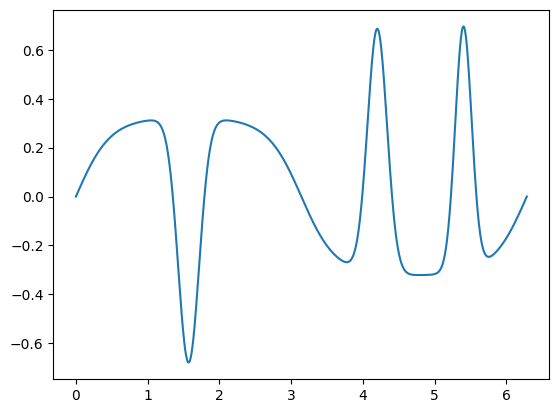

jit complied!
done!
Time: 0.0, Residual: 0.0004166410944890231


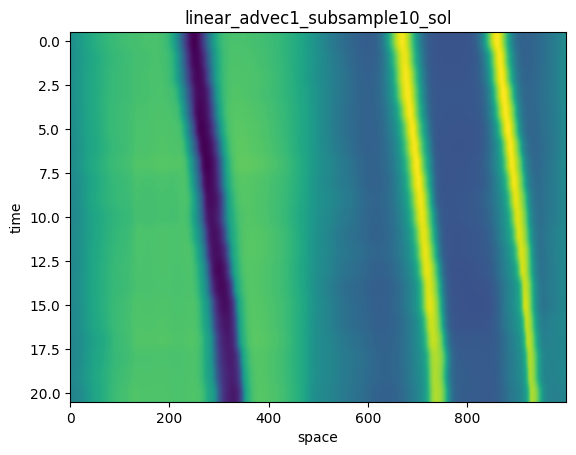

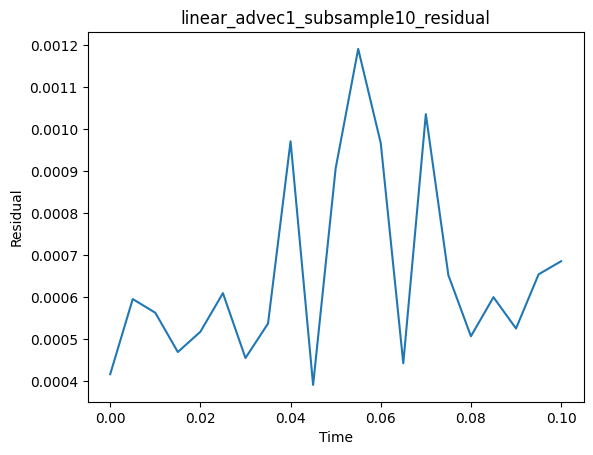

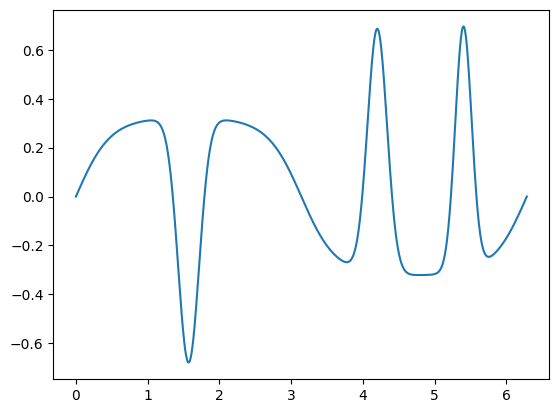

jit complied!
done!
Time: 0.0, Residual: 0.0010080351494252682


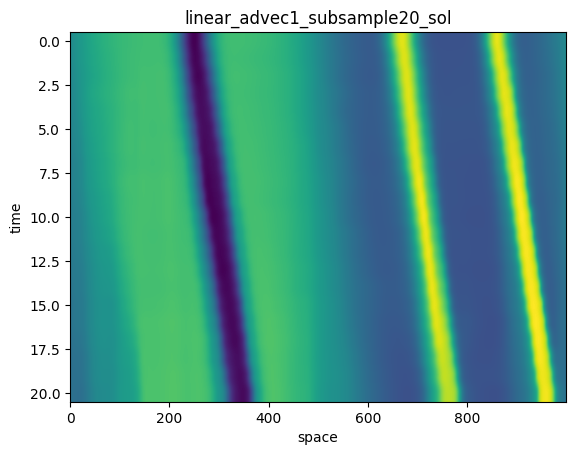

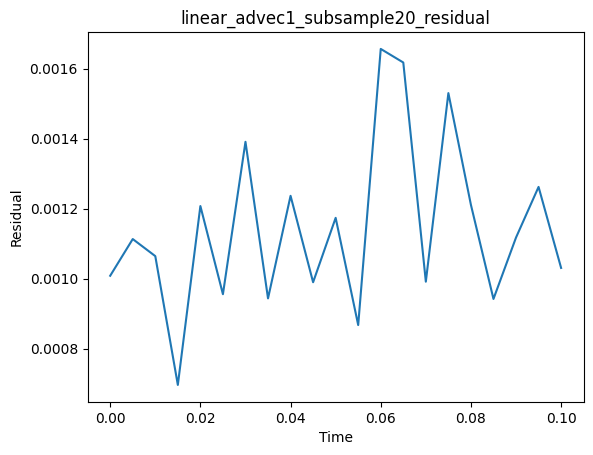

[0.8502984, 1.1382402]
shape of sub_sample_sizes: 2
shape of residuals_subsample: 2


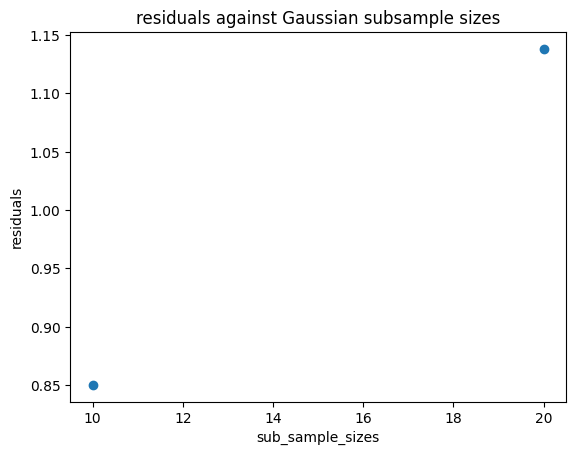

In [3]:

#### test different subsample sizes further
import numpy as np
import matplotlib.pyplot as plt
from jax import jit, vmap, grad
import jax.flatten_util
from time import time
import pandas as pd
import jax
import jax.numpy as jnp
jax.devices()
#sub_sample_sizes = [50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]
sub_sample_sizes = [10,20]#,30,40,125,135,145,155,165]
residuals_subsample=[]
for j in range(len(sub_sample_sizes)):
    # High Speed Settings
    n_x = 1000  # number of sample points in space
    sub_sample = sub_sample_sizes[j]  # number of parameters to randomly sample
    dt = 5e-3  # time step 
    # set up time and space domain
    Tend = 0.1
    t_eval = jnp.linspace(0.0, Tend, int(Tend/dt) + 1)


    dim = 1
    A, B = 0, 2 * jnp.pi
    x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)


    from rsng.dnn import build_nn, init_net

    '''
    test with different PDEs and save the plots
    '''

    ############ define a list of test functions with
    # linear advection equations
    def linear_advec1(t, theta):
        u = U(theta, x_eval)
        u_x = U_dx(theta, x_eval)
        c = lambda t :2*jnp.pi
        return -c(t) * u_x   
    
    test_funcs = [linear_advec1]

    for func_i in range(len(test_funcs)):
        key = jax.random.PRNGKey(func_i)
        width = 25
        depth = 7
        period = 2 * jnp.pi

        net = build_nn(width, depth, period)
        u_scalar, theta_init, unravel = init_net(net, key, dim)

        # used to take gradient and then squeeze
        def gradsqz(f, *args, **kwargs):
            return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))

        # batch the function over X points
        U = vmap(u_scalar, (None, 0))

        # derivative with respect to theta
        U_dtheta = vmap(grad(u_scalar), (None, 0))

        # first spatial derivative
        U_dx = vmap(gradsqz(u_scalar, 1), (None, 0))

        # second spatial derivatives
        U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

        # load the parameters which fit initial condition
        if func_i <3:
            theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
        else:
            theta_0 = pd.read_pickle('./rsng/data/theta_init_burgers.pkl')
        theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]

        # plot initial condition
        plt.plot(x_eval, U(theta_0, x_eval))
        plt.show()

        rhs=test_funcs[func_i]
        # Use Gaussian to subscale the columns of J
        def rhs_reparameterized(t, theta, key):
            key,_= jax.random.split(key)
            J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters
            
            B=jax.random.normal(key,(sub_sample,n_x))
            f = rhs(t, theta)
            # apply B
            J = jnp.dot(B, J)
            f = jnp.dot(B, f)
            theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]
            residual = jnp.linalg.norm(jnp.dot(J, theta_dot) - f)
            return theta_dot, residual

        def odeint_rk4(fn, y0, t, key):
            "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
            def rk4(carry, t):
                y, t_prev, key = carry
                h = t - t_prev
                key, subkey = jax.random.split(key)

                k1, _ = fn(t_prev, y, subkey)
                k2, _ = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
                k3, _ = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
                k4, _ = fn(t, y + h * k3, subkey)

                y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
                return (y, t, key), y

            (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
            return y

        def integrate(y0, t):
            return odeint_rk4(rhs_reparameterized, y0, t, key) 

        # here we separate compile time from integration time
        integrate_complied = jit(integrate).lower(theta_0, t_eval).compile() 
        print('jit complied!')
        time_start = time()
        y = integrate_complied(theta_0, t_eval)
        time_end = time()
        print('done!')

        steps = len(t_eval)
        theta_dot = np.zeros((steps, len(x_eval)))
        residuals = []
        count=0
        
        for i in range(steps):
            theta = y[i, :]
            theta_dot[i] = jnp.squeeze(U(theta, x_eval))
            _, residual = rhs_reparameterized(t_eval[i], theta, key)
            residual_value = jax.device_get(residual)
            residuals.append(residual_value)
            count+=1
            if count%50==1:
                print(f"Time: {t_eval[i]}, Residual: {residual_value}")
        i=0
        # Plotting
        plt.imshow(theta_dot, aspect='auto')
        plt.title(f'{test_funcs[func_i].__name__}_subsample{sub_sample}_sol')
        plt.xlabel('space')
        plt.ylabel('time')
        plt.savefig(f'{test_funcs[func_i].__name__}_subsample{sub_sample}_sol.png')
        plt.show()
        # save the plot as png and name it with the function name

        # Plot residuals over time
        plt.figure()
        plt.plot(t_eval, residuals)
        plt.xlabel('Time')
        plt.ylabel('Residual')
        plt.title(f'{test_funcs[func_i].__name__}_subsample{sub_sample}_residual')
        #save the plots as png
        plt.savefig(f'new_{test_funcs[func_i].__name__}_subsample{sub_sample}_residual.png')
        plt.show()
        #residuals_subsample.append(np.mean(np.array(residuals[-10:])))
        #check error by comparing difference between the initial condition and the final condition
        residuals_subsample.append(np.linalg.norm(y[-1]-y[0]))

print(residuals_subsample)
print('shape of sub_sample_sizes:',len(sub_sample_sizes))
print('shape of residuals_subsample:',len(residuals_subsample))
plt.scatter(sub_sample_sizes,residuals_subsample)
plt.xlabel('sub_sample_sizes')
plt.ylabel('residuals')
plt.title('residuals against Gaussian subsample sizes')
plt.show()
    

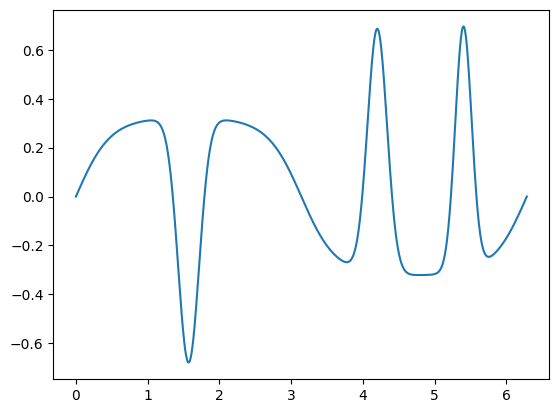

jit complied!
done!
Time: 0.0, Residual: 0.0003478405997157097


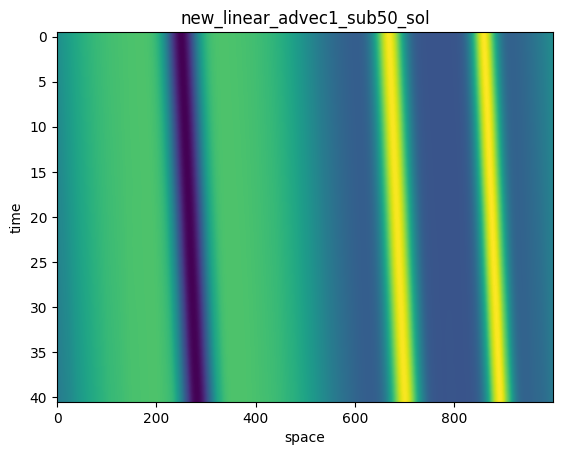

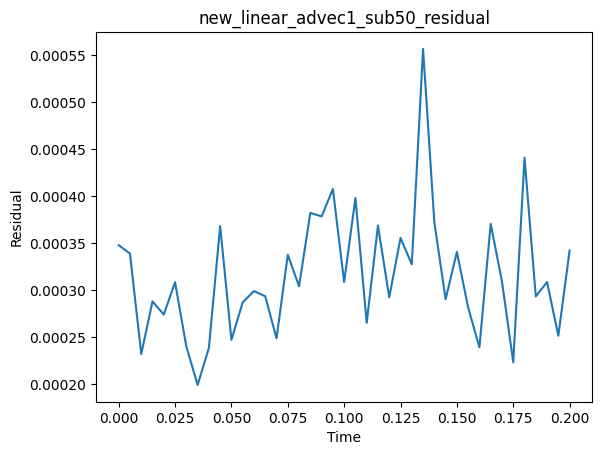

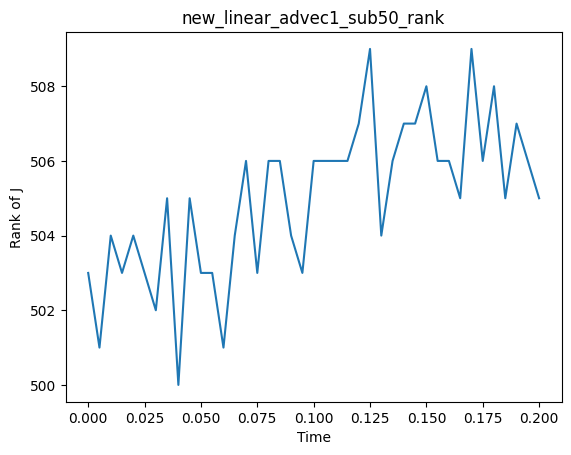

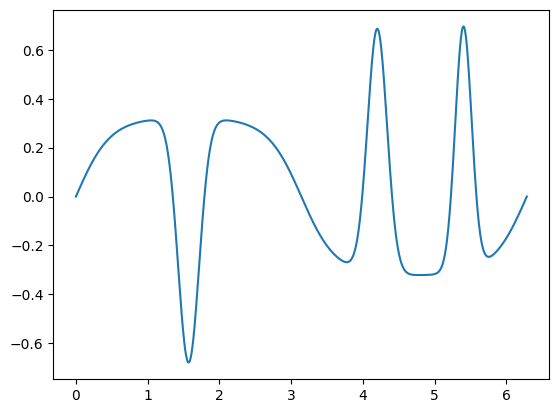

jit complied!
done!
Time: 0.0, Residual: 0.00037083341157995164


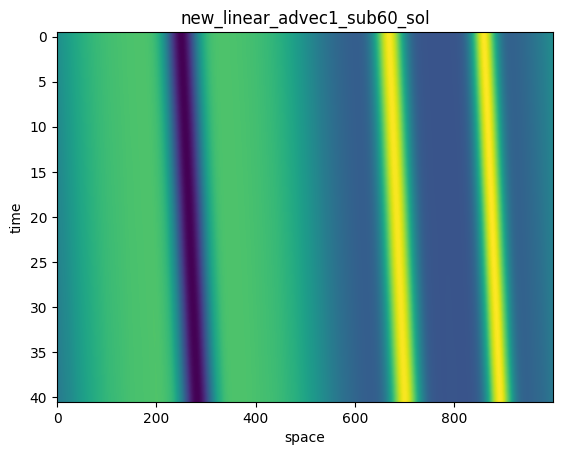

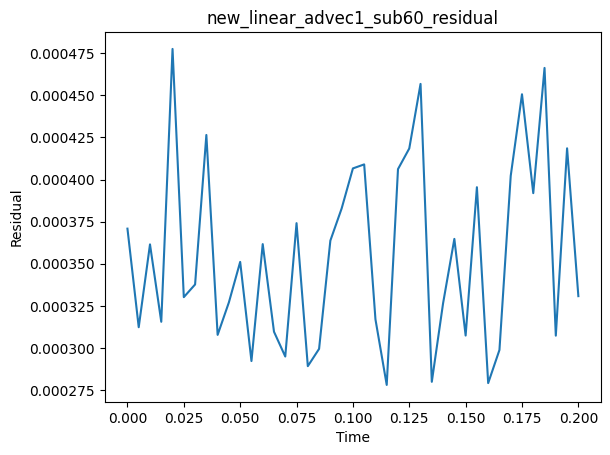

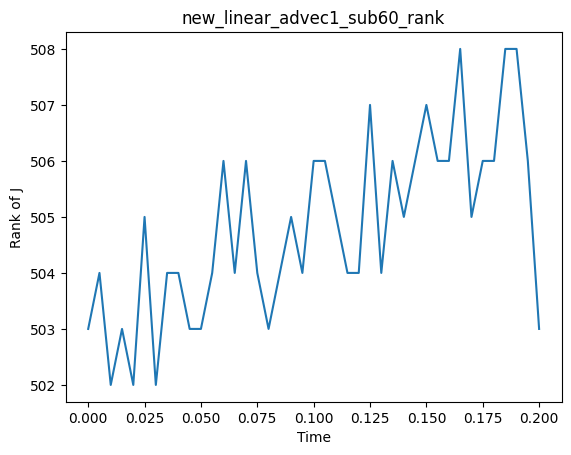

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/polynomial/polynomial.py:1362: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


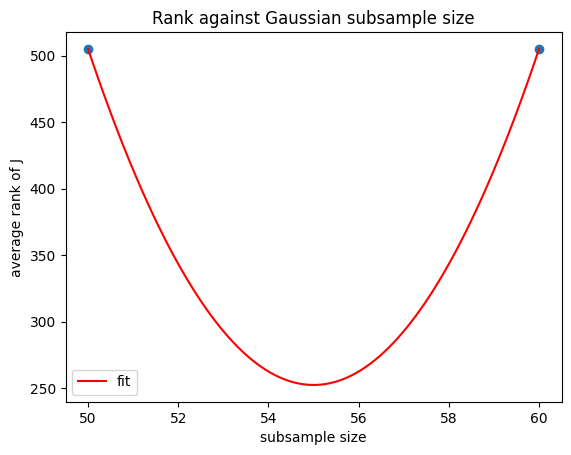

In [6]:

#### test different subsample sizes further
import numpy as np
import matplotlib.pyplot as plt
from jax import jit, vmap, grad
import jax.flatten_util
from time import time
import pandas as pd
import jax
import jax.numpy as jnp
jax.devices()
sub_sample_sizes = [50,60]#,70,80,90,100,110,115,120,125,130,135,140,150]
residuals_subsample=[]
rank_of_J=[]
avg_rank_of_J=[]
for j in range(len(sub_sample_sizes)):
    # High Speed Settings
    n_x = 1000  # number of sample points in space
    sub_sample = sub_sample_sizes[j]  # number of parameters to randomly sample
    dt = 5e-3  # time step 
    # set up time and space domain
    Tend = 0.2
    t_eval = jnp.linspace(0.0, Tend, int(Tend/dt) + 1)


    dim = 1
    A, B = 0, 2 * jnp.pi
    x_eval = jnp.expand_dims(jnp.linspace(A, B, n_x), axis=-1)


    from rsng.dnn import build_nn, init_net

    '''
    test with different PDEs and save the plots
    '''

    ############ define a list of test functions with
    # linear advection equations
    def linear_advec1(t, theta):
        u = U(theta, x_eval)
        u_x = U_dx(theta, x_eval)
        c = lambda t :1.0
        return -c(t) * u_x   
    
    def burgers2(t, theta):
        u = U(theta, x_eval)
        u_x = U_dx(theta, x_eval)
        u_xx = U_ddx(theta, x_eval)
        return 1e-2*u_xx-u_x*u
    
    test_funcs = [linear_advec1]

    for func_i in range(len(test_funcs)):
        key = jax.random.PRNGKey(func_i)
        width = 25
        depth = 7
        period = 2 * jnp.pi

        net = build_nn(width, depth, period)
        u_scalar, theta_init, unravel = init_net(net, key, dim)

        # used to take gradient and then squeeze
        def gradsqz(f, *args, **kwargs):
            return lambda *fargs, **fkwargs: jnp.squeeze(grad(f, *args, **kwargs)(*fargs, **fkwargs))

        # batch the function over X points
        U = vmap(u_scalar, (None, 0))

        # derivative with respect to theta
        U_dtheta = vmap(grad(u_scalar), (None, 0))

        # first spatial derivative
        U_dx = vmap(gradsqz(u_scalar, 1), (None, 0))

        # second spatial derivatives
        U_ddx = vmap(gradsqz(gradsqz(u_scalar, 1), 1), (None, 0))

        # load the parameters which fit initial condition
        if func_i <3:
            theta_0 = pd.read_pickle('./rsng/data/theta_init_ac.pkl')
        else:
            theta_0 = pd.read_pickle('./rsng/data/theta_init_burgers.pkl')
        theta_0 = jax.flatten_util.ravel_pytree(theta_0)[0]

        # plot initial condition
        plt.plot(x_eval, U(theta_0, x_eval))
        plt.show()

        rhs=test_funcs[func_i]
        # Use Gaussian to subscale the columns of J
        def rhs_reparameterized(t, theta, key):
            key,_= jax.random.split(key)
            J = U_dtheta(theta, x_eval)  # take the gradient with respect to the parameters

            # we obtain the rank of batch Jacobian here
            rank_of_J=jnp.linalg.matrix_rank(J,1e-6)
            B=jax.random.normal(key,(sub_sample,n_x))
            f = rhs(t, theta)
            # apply B
            J = jnp.dot(B, J)
            f = jnp.dot(B, f)
            theta_dot = jnp.linalg.lstsq(J, f, rcond=1e-4)[0]
            residual = jnp.linalg.norm(jnp.dot(J, theta_dot) - f)
            return theta_dot, residual ,rank_of_J

        def odeint_rk4(fn, y0, t, key):
            "Adapted from: https://github.com/DifferentiableUniverseInitiative/jax_cosmo/blob/master/jax_cosmo/scipy/ode.py"
            def rk4(carry, t):
                y, t_prev, key = carry
                h = t - t_prev
                key, subkey = jax.random.split(key)

                k1, _,_ = fn(t_prev, y, subkey)
                k2, _,_ = fn(t_prev + h / 2, y + h * k1 / 2, subkey)
                k3, _,_ = fn(t_prev + h / 2, y + h * k2 / 2, subkey)
                k4, _,_ = fn(t, y + h * k3, subkey)

                y = y + 1.0 / 6.0 * h * (k1 + 2 * k2 + 2 * k3 + k4)
                return (y, t, key), y

            (yf, _, _), y = jax.lax.scan(rk4, (y0, jnp.array(t[0]), key), t)
            return y

        def integrate(y0, t):
            return odeint_rk4(rhs_reparameterized, y0, t, key) 

        # here we separate compile time from integration time
        integrate_complied = jit(integrate).lower(theta_0, t_eval).compile() 
        print('jit complied!')
        time_start = time()
        y = integrate_complied(theta_0, t_eval)
        time_end = time()
        print('done!')

        steps = len(t_eval)
        theta_dot = np.zeros((steps, len(x_eval)))
        residuals = []
        rank_of_J = []
        count=0
    
        for i in range(steps):
            theta = y[i, :]
            theta_dot[i] = jnp.squeeze(U(theta, x_eval))
            _, residual, rank = rhs_reparameterized(t_eval[i], theta, key)
            residual_value = jax.device_get(residual)
            rank_value = jax.device_get(rank)
            residuals.append(residual_value)
            rank_of_J.append(rank_value)
            count+=1
            if count%50==1:
                print(f"Time: {t_eval[i]}, Residual: {residual_value}")

        i=0
        
        # Plotting
        plt.imshow(theta_dot, aspect='auto')
        plt.title(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_sol')
        plt.xlabel('space')
        plt.ylabel('time')
        plt.savefig(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_sol.png')
        plt.show()
        # save the plot as png and name it with the function name

        # Plot residuals over time
        plt.figure()
        plt.plot(t_eval, residuals)
        plt.xlabel('Time')
        plt.ylabel('Residual')
        plt.title(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_residual')
        #save the plots as png
        plt.savefig(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_residual.png')
        plt.show()

        #plot ranks over time
        plt.figure()
        plt.plot(t_eval, rank_of_J)
        plt.xlabel('Time')
        plt.ylabel('Rank of J')
        avg_rank_of_J.append(jnp.mean(jnp.array(rank_of_J)))
        plt.title(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_rank')
        #save the plots as png
        plt.savefig(f'new_{test_funcs[func_i].__name__}_sub{sub_sample}_rank.png')
        plt.show()


# print(residuals_subsample)
# print('shape of sub_sample_sizes:',len(sub_sample_sizes))
# print('shape of residuals_subsample:',len(residuals_subsample))
plt.scatter(sub_sample_sizes,avg_rank_of_J)

plt.xlabel('subsample size')
plt.ylabel('average rank of J')
plt.title('Rank against Gaussian subsample size')
#fit a least square curve to the scatterplot
from numpy.polynomial import Polynomial
p = Polynomial.fit(sub_sample_sizes, avg_rank_of_J, 2)
plt.plot(*p.linspace(), label='fit', color='red')
plt.legend()

plt.savefig('rank_against_Gaussian_subsample_size.png')
plt.show()

    
#finally plot 